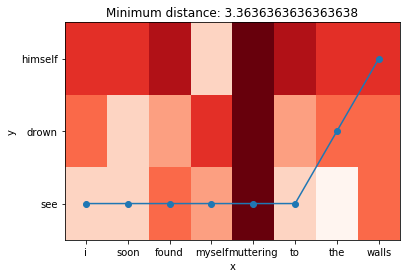

In [1]:
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist


def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path


def fastdtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences in a faster way.
    Instead of iterating through each element and calculating each distance,
    this uses the cdist function from scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)
    :param array x: N1*M array
    :param array y: N2*M array
    :param string or func dist: distance parameter for cdist. When string is given, cdist uses optimized functions for the distance metrics.
    If a string is passed, the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    if ndim(x) == 1:
        x = x.reshape(-1, 1)
    if ndim(y) == 1:
        y = y.reshape(-1, 1)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]
    D0[1:, 1:] = cdist(x, y, dist)
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                min_list += [D0[min(i + k, r - 1), j],
                             D0[i, min(j + k, c - 1)]]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path


def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)


if __name__ == '__main__':
    if 0:  # 1-D numeric
        from sklearn.metrics.pairwise import manhattan_distances
        x = [0, 0, 1, 1, 2, 4, 2, 1, 2, 0]
        y = [1, 1, 1, 2, 2, 2, 2, 3, 2, 0]
        dist_fun = manhattan_distances
    elif 0:  # 2-D numeric
        from sklearn.metrics.pairwise import euclidean_distances
        x = [[0, 0], [0, 1], [1, 1], [1, 2], [2, 2], [4, 3], [2, 3], [1, 1], [2, 2], [0, 1]]
        y = [[1, 0], [1, 1], [1, 1], [2, 1], [4, 3], [4, 3], [2, 3], [3, 1], [1, 2], [1, 0]]
        dist_fun = euclidean_distances
    else: # 1-D list of strings
        from nltk.metrics.distance import edit_distance
        # x = ['we', 'shelled', 'clams', 'for', 'the', 'chowder']
        # y = ['class', 'too']
        x = ['i', 'soon', 'found', 'myself', 'muttering', 'to', 'the', 'walls']
        y = ['see', 'drown', 'himself']
        # x = 'we talked about the situation'.split()
        # y = 'we talked about the situation'.split()
        dist_fun = edit_distance
    dist, cost, acc, path = dtw(x, y, dist_fun)

    # Vizualize
    from matplotlib import pyplot as plt
    plt.imshow(cost.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
    plt.plot(path[0], path[1], '-o') # relation
    plt.xticks(range(len(x)), x)
    plt.yticks(range(len(y)), y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('tight')
    plt.title('Minimum distance: {}'.format(dist))
plt.show()

In [2]:
import numpy as np
import pandas as pd
import pylab as pl

%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [3]:
def znormalization(ts):
    """
    ts - each column of ts is a time series (np.ndarray)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

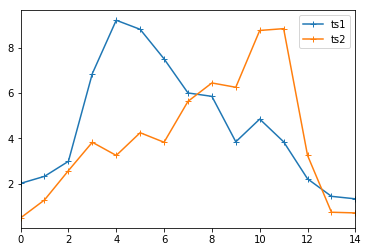

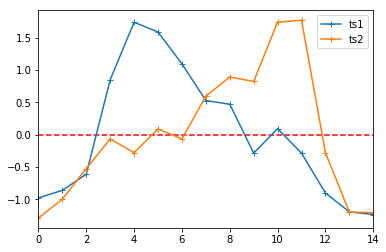

In [4]:
ts1 = np.asarray([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34])
ts2 = np.asarray([0.50, 1.29, 2.58, 3.83, 3.25, 4.25, 3.83, 5.63, 6.44, 6.25, 8.75, 8.83, 3.25, 0.75, 0.72])
ts = pd.DataFrame({"ts1": ts1, "ts2": ts2})
ts.plot(style = "-+")

zts = znormalization(ts)
zts.plot(style = "-+")
plt.hlines(0, 0, 14, colors = 'r', linestyles='--')

In [5]:
def paa_transform(ts, n_pieces):
    """
    ts: the columns of which are time series represented by e.g. np.array
    n_pieces: M equally sized piecies into which the original ts is splitted
    """
    splitted = np.array_split(ts, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [6]:
import math
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import itertools as itools
import matplotlib.pyplot as plt
sns.set_style("dark")




In [11]:
t1 = np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34,0.5,1.8,2,2.2,3.5,6,8,1,5,7,9,1,5,7,8,0,1,4,6,7,8]).reshape(-1,1)
t2 = np.array([3.12, 2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45,1.34,1.8,2.2,3.5,6,8,1,5,7,9,1,5,7,8,0,1,4,6,7,8]).reshape(-1,1)

In [12]:
def paa(arr, sections):
    try:
        assert arr.shape[0] != sections
    except AssertionError as e:
        return np.copy(arr)
    else:
        if arr.shape[0] % sections == 0:
            sectionarr = np.array_split(arr, sections)
            res = np.array([item.mean() for item in sectionarr])
            res = np.array(
                [sample for item in res for sample in 
                [item.mean()] * item.shape[0]]
            )
        else:
            sectionarr = np.zeros(sections)
            space_size = np.arange(0, arr.shape[0] * sections - 1)
            outputIndex = space_size // arr.shape[0]
            inputIndex = space_size // sections
            uniques, nUniques = np.unique(outputIndex, return_counts=True)
            
            res = [arr[indices].sum() / arr.shape[0] for indices in
                   np.split(inputIndex, nUniques.cumsum())[:-1]]
            indices = ([row.mean() for row in np.split(inputIndex, nUniques.cumsum())[:-1]])
    return res

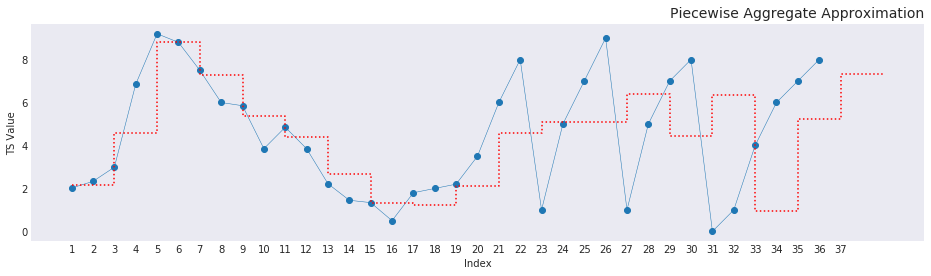

In [21]:


plt.figure(figsize=(16, 4))
plt.title("Piecewise Aggregate Approximation", size=14, loc="right")
plt.plot(range(1, 37), t1, marker="o", linewidth=0.5)
res = paa(t1, 19)
plt.step([1, 3, 5, 7, 9, 11, 13, 15,17,19,21,23,25,27,29,31,33,35,37,39], np.insert(res, 0, res[0]),
         color="red", linestyle=":")
plt.xticks(range(1, 38))
plt.xlabel("Index")
plt.ylabel("TS Value")
plt.savefig("./PAAStepFinal.png", bbox_inches="tight")
plt.show()



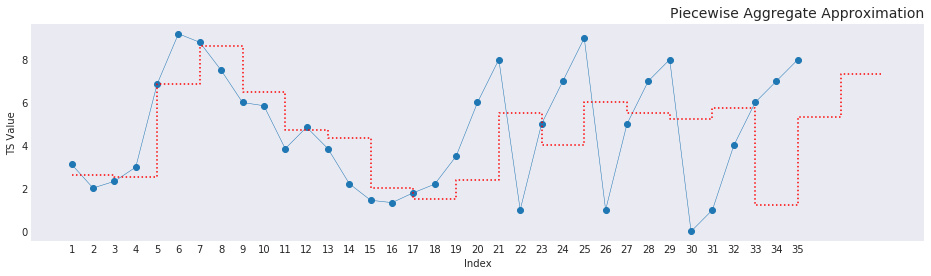

In [26]:


plt.figure(figsize=(16, 4))
plt.title("Piecewise Aggregate Approximation", size=14, loc="right")
plt.plot(range(1, 36), t2, marker="o", linewidth=0.5)
res1 = paa(t2, 19)
plt.step([1, 3, 5, 7, 9, 11, 13, 15,17,19,21,23,25,27,29,31,33,35,37,39], np.insert(res1, 0, res1[0]),
         color="red", linestyle=":")
plt.xticks(range(1, 36))
plt.xlabel("Index")
plt.ylabel("TS Value")
plt.savefig("./PAAStepFinal.png", bbox_inches="tight")
plt.show()



In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/fractaluser/downloads/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


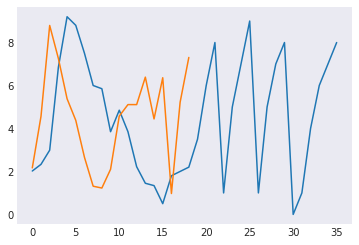

In [28]:
plot(t1)
plot(res)

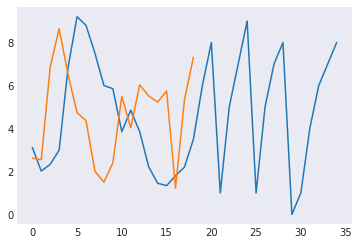

In [29]:
plot(t2)
plot(res1)

In [30]:
x= np.array(res).reshape(-1,1)
y= np.array(res1).reshape(-1,1)

In [31]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))



In [32]:
print('Minimum distance found:', dist)

Minimum distance found: 0.303718253968


(-0.5, 18.5)

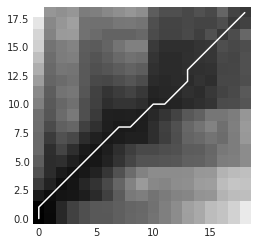

In [33]:
imshow(acc.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot(path[0], path[1], 'w')
xlim((-0.5, acc.shape[0]-0.5))
ylim((-0.5, acc.shape[1]-0.5))

In [40]:
x1=t1
y1=t2

In [41]:
dist, cost, acc, path = dtw(x1, y1, dist=lambda x1, y1: norm(x1 - y1, ord=1))

In [42]:
print('Minimum distance found:', dist)

Minimum distance found: 0.0301408450704


(-0.5, 34.5)

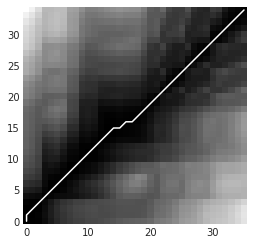

In [43]:
imshow(acc.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot(path[0], path[1], 'w')
xlim((-0.5, acc.shape[0]-0.5))
ylim((-0.5, acc.shape[1]-0.5))